# 라이브러리 불러오기

In [16]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [77]:
BASE_PATH = os.path.join("../../..", "data")

train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

interest_data = pd.read_csv(os.path.join(BASE_PATH, 'interestRate.csv'))

# 데이터 EDA 수행하기

In [78]:
print("train, test_data, sample_submission info : ", "\n", train_data.info(), test_data.info(), sample_submission.info(), interest_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
dtypes: float64(4), int64(7)
memory usage: 151.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150172 entries, 0 to 150171
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                150172 non-null  int64  
 1   area_m2              150172 non-null  float64
 2   contract_year_month  150172 non-null  int64  
 3   contract_day         1

In [81]:
# 월별 거래량 확인
monthly_transaction = train_data.groupby('contract_year_month').size().reset_index(name='monthly_transaction')

# 월별 평균 deposit 계산
monthly_avg_deposit = train_data.groupby('contract_year_month')['deposit'].mean().reset_index(name='avg_deposit')

# Merge with interest_data
deposit_and_interest_df = pd.merge(monthly_transaction, 
                                   interest_data[['year_month', 'interest_rate']], 
                                   left_on='contract_year_month', 
                                   right_on='year_month', 
                                   how='left')

# Merge with monthly_avg_deposit
deposit_and_interest_df = pd.merge(deposit_and_interest_df, 
                                   monthly_avg_deposit, 
                                   on='contract_year_month', 
                                   how='left')[['year_month', 'monthly_transaction', 'interest_rate', 'avg_deposit']]

# Convert year_month to datetime
deposit_and_interest_df["year_month"] = pd.to_datetime(deposit_and_interest_df["year_month"], format='%Y%m')

# Display the first few rows
deposit_and_interest_df.head()

,year_month,monthly_transaction,interest_rate,avg_deposit
0,2019-04-01,22136,1.85,30447.425958
1,2019-05-01,22860,1.85,31132.991601
2,2019-06-01,23533,1.78,31111.287554
3,2019-07-01,25951,1.68,31621.427691
4,2019-08-01,25862,1.52,31712.702769


In [46]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False 

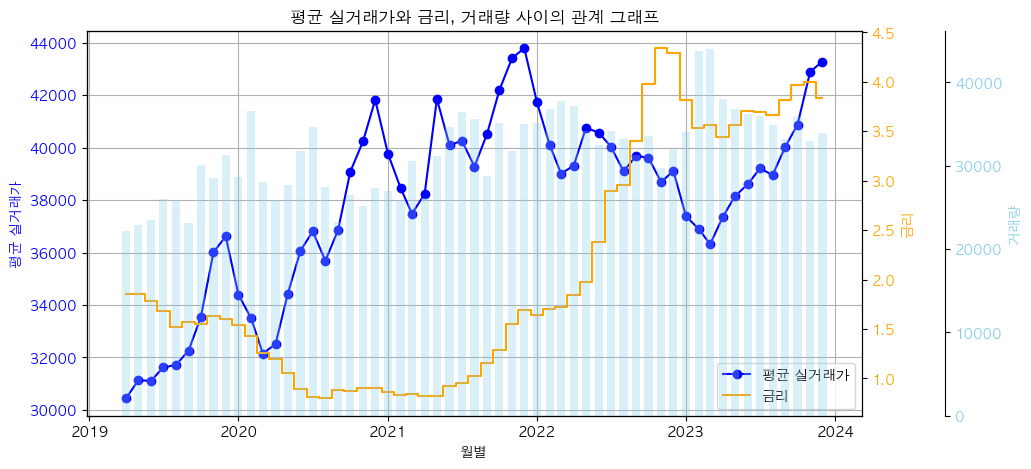

In [110]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 첫 번째 y축 (평균 실거래가)
ax1.set_xlabel('월별')
ax1.set_ylabel('평균 실거래가', color='b')
line1 = ax1.plot(deposit_and_interest_df['year_month'], deposit_and_interest_df['avg_deposit'], label='평균 실거래가', marker='o', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축 (금리)
ax2 = ax1.twinx()
ax2.set_ylabel('금리', color='orange')
line2 = ax2.step(deposit_and_interest_df['year_month'], deposit_and_interest_df['interest_rate'], label='금리', where='mid', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 세 번째 y축 (거래량)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 세 번째 축을 조금 오른쪽으로 이동
ax3.set_ylabel('거래량', color='skyblue')
line3 = ax3.bar(deposit_and_interest_df['year_month'], deposit_and_interest_df['monthly_transaction'], label='거래량', color='skyblue', alpha=0.3, width=20)
ax3.tick_params(axis='y', labelcolor='skyblue')

# 제목과 범례
plt.title('평균 실거래가와 금리, 거래량 사이의 관계 그래프')

# 첫 번째 y축의 그리드 설정
ax1.grid(True)

# 범례 추가
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')

plt.show()

In [85]:
cor_m = deposit_and_interest_df[['avg_deposit', 'interest_rate']].corr()
cor_m

,avg_deposit,interest_rate
avg_deposit,1.000000,0.206548
interest_rate,0.206548,1.000000


- 육안상으로는 실거래가와 금리의 관계가 반비례 관계인 것처럼 보이나, 실제 상관관계 확인시 0.21이라는 애매한 수치임을 볼 수 있음.
- 평균 실거래가의 차이로 비교하면 금리 변동에 따른 실거래가의 변화를 확인할 수 있을 것 같음.

In [104]:
deposit_and_interest_df["deposit_diff"] = deposit_and_interest_df["avg_deposit"].diff()
deposit_and_interest_df["deposit_diff"] = deposit_and_interest_df["deposit_diff"].fillna(0)

cor_m2 = deposit_and_interest_df.drop(columns=['year_month']).corr()
cor_m2

,monthly_transaction,interest_rate,avg_deposit,deposit_diff
monthly_transaction,1.000000,0.469879,0.466751,-0.167065
interest_rate,0.469879,1.000000,0.206548,-0.049724
avg_deposit,0.466751,0.206548,1.000000,0.131533
deposit_diff,-0.167065,-0.049724,0.131533,1.000000


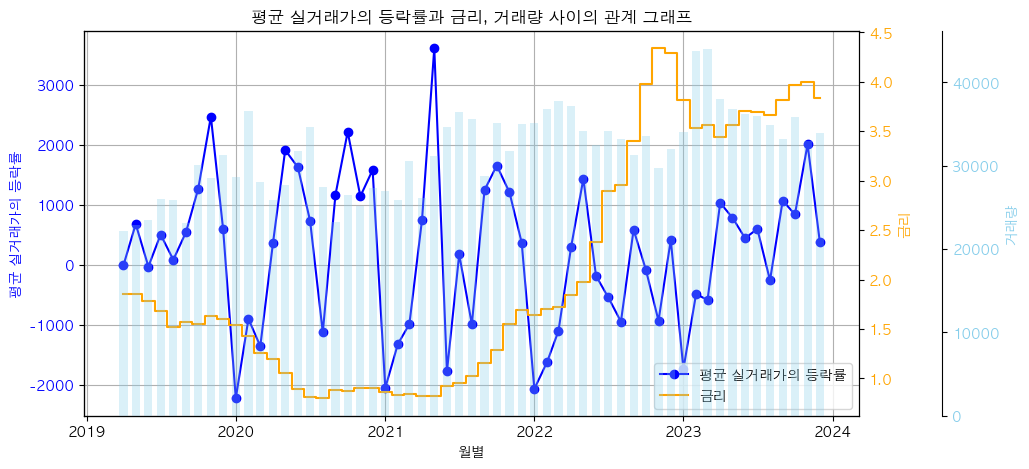

In [109]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 첫 번째 y축 (평균 실거래가의 등락률)
ax1.set_xlabel('월별')
ax1.set_ylabel('평균 실거래가의 등락률', color='b')
line1 = ax1.plot(deposit_and_interest_df['year_month'], deposit_and_interest_df['deposit_diff'], label='평균 실거래가의 등락률', marker='o', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축 (금리)
ax2 = ax1.twinx()
ax2.set_ylabel('금리', color='orange')
line2 = ax2.step(deposit_and_interest_df['year_month'], deposit_and_interest_df['interest_rate'], label='금리', where='mid', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 세 번째 y축 (거래량)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 세 번째 축을 조금 오른쪽으로 이동
ax3.set_ylabel('거래량', color='skyblue')
line3 = ax3.bar(deposit_and_interest_df['year_month'], deposit_and_interest_df['monthly_transaction'], label='거래량', color='skyblue', alpha=0.3, width=20)
ax3.tick_params(axis='y', labelcolor='skyblue')

# 제목과 범례
plt.title('평균 실거래가의 등락률과 금리, 거래량 사이의 관계 그래프')

# 첫 번째 y축의 그리드 설정
ax1.grid(True)

# 범례 추가
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')

plt.show()